# Brovey Pan Sharpening Landsat <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3)

## Description
In this example we will load Landsat 8 data and use the Brovey Transformation along with the panchromatic band to generate a higher resolution RGB image.

1. First we will define our area of interest
2. Then we will set up the Brovey Transform
3. Load data at upsampled 15m^2 resolution and load data at native 30m^2 resolution for reference
4. Plot and compare the outputs

***

## Getting started

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numexpr
import sys


sys.path.append('../Scripts')
from dea_plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='pan-sharpening')

### Analysis parameters

* `product`: The name of the product, this method should work with DEA Landsat Collection 3 ARD from Landsat 7 and Landsat 8 - `ga_ls8c_ard_3` and `ga_ls7e_ard_3` are valid choices
* `resolution`: Most Landsat bands collect data at a 30m^2 resolution, with the exception of the panchromatic band which is at 15m^2 - unless you are using this example with a different sensor leave this at `(15, -15)`
* `align`: Alignment of the centre of the pixel = leave this at `(7.5,7.5)` unless you know the data you are using requires a different pixel alignment
* `resampling`: When we use the DataCube to upsample the red, green and blue bands this is the resampling method to use. It is suggested to use `'bilinear'` however if you wish to experiment with different resampling methods you can use any of the available methods here: https://github.com/mapbox/rasterio/blob/master/rasterio/enums.py#L28
* `lon,lat,time`: Parameters to define our area of interest - feel free to adjust these
* `measurements`: Landsat 7 and Landsat 8 have slightly different sensor configurations. For Landsat 8, pan-sharpening should only be used with red, green and blue. For Landsat 7, pan-sharpening can be used with red, green, blue and near infrared (`nbart_nir` or `nbar_nir`). For a visual explanation see: https://landsat.gsfc.nasa.gov/wp-content/uploads/2013/01/ETM+vOLI-TIRS-web_Feb20131.jpg. An alternative selection of measurements could be `['nbart_red','nbart_green','nbart_blue','nbart_panchromatic']` but ensure that all your measurements are either terrain corrected (`nbart_`) or non-terrain corrected (`nbar_`).


In [3]:
# currently this is only available from Landsat 7 and Landsat 8 in GA Landsat collection 3
product = 'ga_ls8c_ard_3'

# we want to retrieve all data at the panchromatic band resolution
resolution = (15, -15)
align = (7.5,7.5)
resampling = 'bilinear'

#Parliament House
lon=(149.11, 149.14)
lat=(-35.31, -35.29)

#an arbitrary time
time='2018-12-28'

#let's retrieve the red, green, blue and pan bands - this pan sharpening should only be used with red, green and blue
measurements = ['nbar_red','nbar_green','nbar_blue', 'nbar_panchromatic']

## Pan-sharpening Landsat 8 using the Brovey Transform
In this example we use the Brovey Transform, Landsat 8's panchromatic band along with bilinear interpolation from Datacube to pan-sharpen the red, green and blue Landsat bands from 30m^2 resolution to 15m^2. For those familiar, Brovey is primarily for visual analysis and is not "great" at transforming Landsat's Blue band.

In [4]:
def brovey_pan_sharpen_three_bands(band_1,band_2,band_3,pan_band):
    ''' Brovey pan sharpening on nbar input using numexpr 
        return three xarrays
    '''   
    # calculate total
    exp = 'band_1 + band_2 + band_3'
    total = numexpr.evaluate(exp)
    
    # perform brovey transform in form of: band/total*panchromatic
    exp = 'a/b*c'
    band_1_sharpen = numexpr.evaluate(exp,local_dict={'a':band_1,'b':total,'c':pan_band})
    band_2_sharpen = numexpr.evaluate(exp,local_dict={'a':band_2,'b':total,'c':pan_band})
    band_3_sharpen = numexpr.evaluate(exp,local_dict={'a':band_3,'b':total,'c':pan_band})
    
    return band_1_sharpen, band_2_sharpen, band_3_sharpen
    

## Determine native resolution (Optional)
This section has some optional extra steps to ensure that data you load is in 'native projection' to ensure maximum fidelity of your data. If this is not required, or you intend on re-projecting to a different CRS (like 'epsg:3577') then simply nominate your target CRS.

In [5]:
# for the purposes of using our target dataset's native projection, let's find determine it's native crs before loading - while this yeilds best results, it is optional
md = dc.find_datasets(product=product, lon=lon, lat=lat, time=time, limit=1)[0].metadata_doc
id = md['id'] #ensure we only return the exact dataset that we want (optional)
output_crs = md['crs'] #using native projection (optional)

## Load Data

In [6]:
# load red, green, blue and panchromatic band for our area of interest at 15m resolution
nbar_rgbp_15m = dc.load(product=product, id=id, resolution=resolution, align=align, output_crs=output_crs, resampling=resampling, lon=lon, lat=lat, measurements=measurements)

In [7]:
# for reference, lets load the same image at 30m resolution
nbar_rgb_30m = dc.load(product=product, id=id, resolution=(30,-30), align=(15,15), output_crs=output_crs, lon=lon, lat=lat, measurements=['nbar_red','nbar_green','nbar_blue'])

## Pass Xarrays to Brovey Pan Sharpening function

In [8]:
# perform brovey pan-sharpening, pass xarrays to Brovey pan-sharpent function - Note if you choose to access different measurements, they will need to be altered here
red_sharpen, green_sharpen, blue_sharpen = brovey_pan_sharpen_three_bands(band_1=nbar_rgbp_15m.nbar_red.values,
                                                                   band_2=nbar_rgbp_15m.nbar_green.values,
                                                                   band_3=nbar_rgbp_15m.nbar_blue.values,
                                                                   pan_band=nbar_rgbp_15m.nbar_panchromatic.values)

## Reconstruct dataset (optional depending on your use case)

In [9]:
# Copy the coordinates and dimensions from the original dataset
time = nbar_rgbp_15m.time
y = nbar_rgbp_15m.y
x = nbar_rgbp_15m.x
coords = [time, y, x]
dims = ['time', 'y', 'x']

#Create new data arrays
red_data_array = xr.DataArray(red_sharpen, coords=coords, dims=dims)
green_data_array = xr.DataArray(green_sharpen, coords=coords, dims=dims)
blue_data_array = xr.DataArray(blue_sharpen, coords=coords, dims=dims)

sharp_rgb = xr.Dataset({'red': red_data_array, 'green': green_data_array, 'blue': blue_data_array}, coords={'time': time, 'y': y,'x': x})

## Plot Red, Green and Blue bands at native 30m^2 resolution

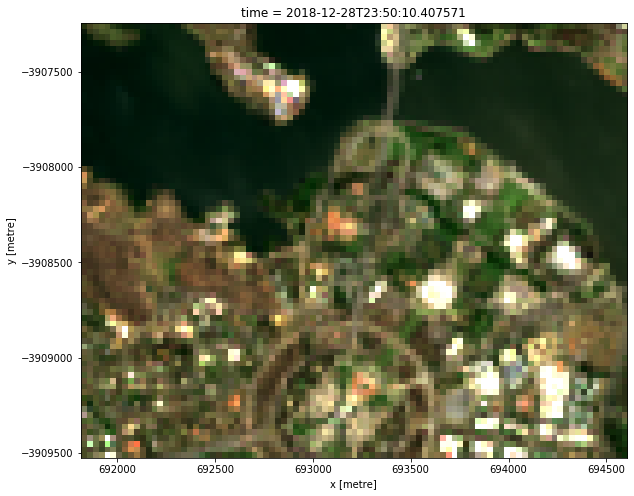

In [10]:
rgb(ds=nbar_rgb_30m, bands=['nbar_red','nbar_green','nbar_blue'], size=8)

## Plot Red, Green and Blue bands at interporlated 15m^2 resolution

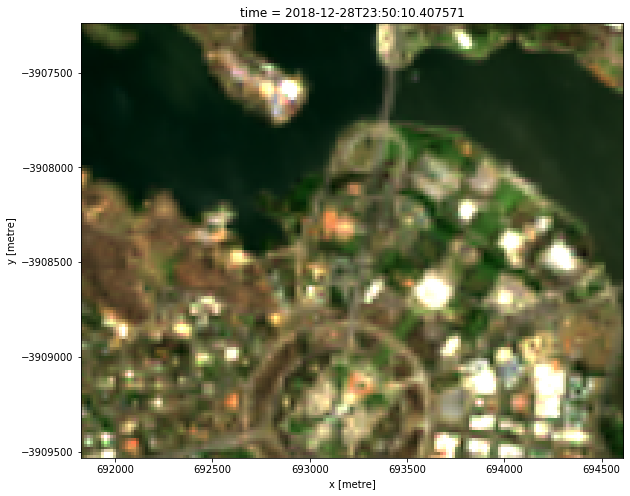

In [11]:
rgb(ds=nbar_rgbp_15m, bands=['nbar_red','nbar_green','nbar_blue'], size=8)

## Plot Pan Sharpened Red, Green and Blue bands at 15m^2 resolution

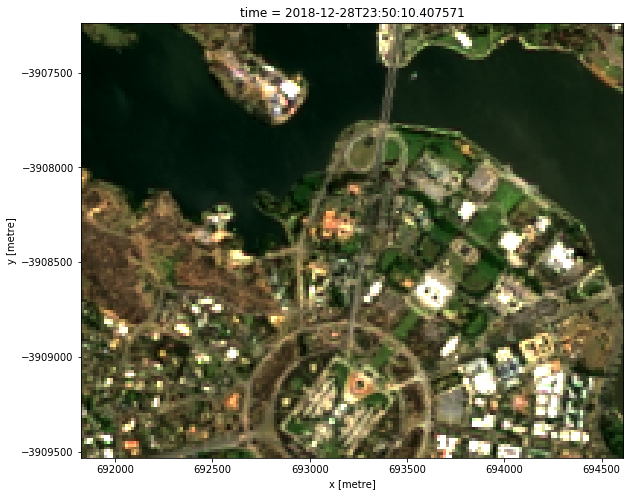

In [12]:
rgb(ds=sharp_rgb, bands=['red','green','blue'], size=8, index=0)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2019

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.7+138.g59cc64f9.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)